# Bibliotecas

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Base

In [8]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'Bitcoin Historical Data.csv'

# Ler arquivo da base
df = pd.read_csv(caminho)

# Formatar data
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
# df = df[df['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if df[coluna].dtype == 'object':  
        df[coluna] = pd.to_numeric(df[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if df['Change %'].dtype == 'object':  
    df['Change %'] = pd.to_numeric(df['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if 'K' in valor:
        return float(valor.replace('K', '').replace(',', '')) * 1000
    elif 'M' in valor:
        return float(valor.replace('M', '').replace(',', '')) * 1000000
    elif 'B' in valor:
        return float(valor.replace('B', '').replace(',', '')) * 1000000000
    else:
        return float(valor.replace(',', ''))

# Aplicar a função na coluna 'Vol.'
df['Vol.'] = df['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
df = df.sort_values(by='Date', ascending=True)

df = df.rename(columns={'Vol.': 'Volume'})

df

,Date,Price,Open,High,Low,Volume,Change %
1598,2020-01-01,7199.8,7196.4,7259.4,7180.0,420280.0,0.05
1597,2020-01-02,6967.0,7199.7,7209.6,6901.4,632780.0,-3.23
1596,2020-01-03,7343.1,6967.1,7402.9,6884.1,936290.0,5.40
1595,2020-01-04,7376.8,7345.1,7433.1,7291.4,523910.0,0.46
1594,2020-01-05,7372.5,7376.8,7501.0,7345.6,628140.0,-0.06
...,...,...,...,...,...,...,...
4,2024-05-13,62937.2,61480.5,63443.2,60779.0,70550.0,2.37
3,2024-05-14,61569.4,62936.8,63102.6,61156.9,68840.0,-2.17
2,2024-05-15,66225.1,61569.4,66417.1,61357.5,106050.0,7.56
1,2024-05-16,65231.0,66219.6,66643.9,64623.3,72550.0,-1.50


# Algoritmo

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.2303
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0121
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0058
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0045
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0042
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0042
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0038
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0036
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0032
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0031
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0031
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0031
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0026
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0028
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029
Epoc

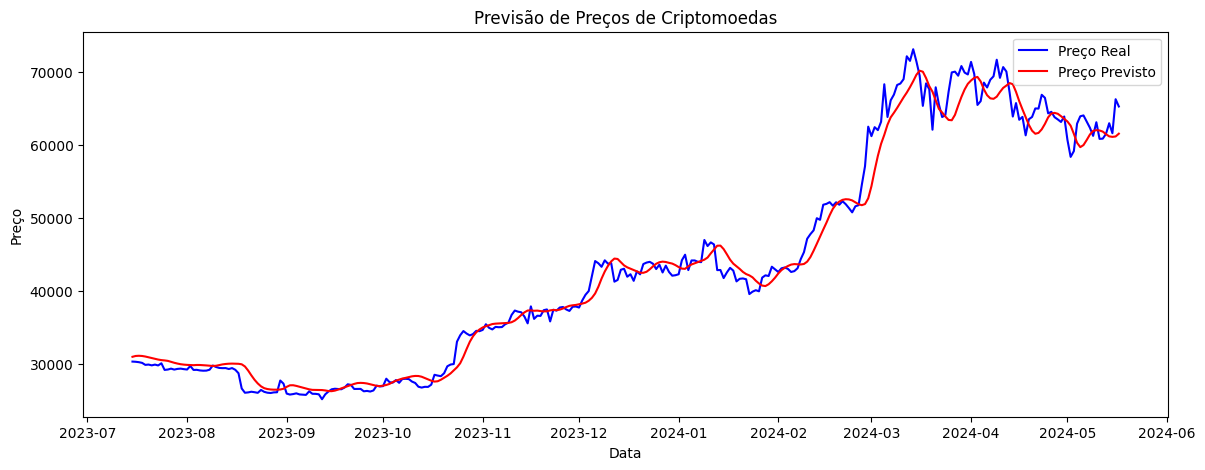

In [9]:
# Selecionar apenas as colunas que serão utilizadas
df = df[['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %']]

# Converter a coluna "Date" para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar os dados pela data
df = df.sort_values('Date')

# Normalizando os dados entre 0 e 1 (utilizando as colunas de features para predição)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Price', 'Open', 'High', 'Low', 'Volume', 'Change %']])

# Função para criar a sequência de dados para treinamento (usualmente, 60 dias de dados anteriores para prever o próximo)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), :])
        y.append(data[i + look_back, 0])  # A coluna 0 é a "Price"
    return np.array(X), np.array(y)

# Configuração do número de dias anteriores que o modelo irá considerar
look_back = 60
X, y = create_dataset(scaled_data, look_back)

# Dividindo os dados em treino e teste (80% treino e 20% teste)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape dos dados para [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Construção do modelo LSTM
model = Sequential()

# Primeira camada LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Evitar overfitting

# Segunda camada LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada Densa
model.add(Dense(units=25))

# Camada de Saída
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, batch_size=64, epochs=50)

# Fazendo previsões no conjunto de testes
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]  # Desnormalizando apenas a coluna de "Price"

# Desnormalizar os dados de y_test para comparação
y_test_descaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# Avaliando o modelo
mse = mean_squared_error(y_test_descaled, predicted_prices)
print(f'Mean Squared Error: {mse}')

# Visualizando as previsões
plt.figure(figsize=(14,5))
plt.plot(df['Date'][-len(y_test):], y_test_descaled, color='blue', label='Preço Real')
plt.plot(df['Date'][-len(y_test):], predicted_prices, color='red', label='Preço Previsto')
plt.title('Previsão de Preços de Criptomoedas')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [10]:
predicted_prices

array([30972.92454012, 31087.04873912, 31112.54751321, 31084.1039134 ,
       31009.65351285, 30906.50326385, 30792.2163673 , 30688.16721431,
       30594.4412211 , 30519.40104192, 30475.92418815, 30414.94514505,
       30284.38849314, 30154.57618253, 30045.80066561, 29957.28099412,
       29901.34150774, 29865.30399961, 29844.65768005, 29824.61740888,
       29852.38988129, 29850.15685737, 29827.31818827, 29791.88266109,
       29755.4302742 , 29717.86340907, 29744.24888483, 29839.63846052,
       29931.13956469, 29990.76821809, 30027.50125827, 30041.11904351,
       30033.91560932, 30014.51799349, 29945.30238673, 29650.23410346,
       29093.31224249, 28432.21513793, 27822.89652981, 27324.24479768,
       26931.47256601, 26679.01477203, 26559.39139572, 26497.55005559,
       26473.15762486, 26474.4714076 , 26495.89460798, 26595.5590619 ,
       26861.37025759, 27070.7498068 , 27080.61334599, 26989.99894349,
       26871.36395482, 26753.20485649, 26631.698256  , 26518.68040037,
      